<a href="https://colab.research.google.com/github/clarafreijo/CXR-Scatter-Correction/blob/main/SCATTER_CORRECTION_CXR_CFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SCATTER ESTIMATION AND CORRECTION - CXR (Projections of COVID-19 CTs)





# Connect to Google Drive account

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Install required libraries

In [2]:
!pip install -q opencv-python
!pip install -q keras-unet

# Load Libraries

In [3]:
import tensorflow as tf
tf.version.VERSION
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import clear_output
import cv2
import sklearn.model_selection as sk
import pandas as pd
import glob
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_absolute_percentage_error
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

from pylab import array, plot, show, axis, arange, figure, uint8
from scipy.io import loadmat
from skimage import measure
import math
from skimage.morphology import convex_hull_image
import scipy.ndimage as nd
from scipy import stats

# Check GPU

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!nvidia-smi

Sun Nov 19 15:26:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Images from Drive

## Image Parameters

In [ ]:
# Images are expected as float32 values (Little Endian)
Nx = 2050      # Number of pixels in x
Ny = 2050      # Number of pixels in y
Nz = 130       # Total Number of images

## Option 1: Load images saved in .raw format

In [ ]:
def load_raw(folder):
  filelist = glob.glob(folder)
  PROJ = np.zeros((Nz,Nx,Ny),dtype='float32')
  i = 0
  for filename in np.sort(filelist):
    PROJ_single = np.fromfile(filename,dtype='float32')
    PROJ_single = np.reshape(PROJ_single,(2050,2050))
    print(filename)
    PROJ[i,:,:] = PROJ_single
    i = i+1

  # Change image size to 128x128 (to avoid memory troubles in Colab)
  PROJ = np.expand_dims(PROJ,axis=-1)
  PROJ = tf.convert_to_tensor(PROJ, tf.float32)

  Nx2 = 128
  Ny2 = 128

  PROJ = tf.image.resize(PROJ,[Nx2,Ny2],method='bilinear')

  return PROJ


### Low Energy

No Scatter

In [ ]:
PROJ_LE_NS = load_raw('drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/*.raw')


drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0003.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0011.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0013.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0014.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0016.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0025.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0031.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0034.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A-0038.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/NO_SCATTER/P_NSLE_A

In [ ]:
# Save images in .csv to for a quicker load next times
PROJ_LE_NS_np = np.squeeze(PROJ_LE_NS.numpy()).reshape(-1,128)
PROJ_LE_NS_pd = pd.DataFrame(PROJ_LE_NS_np)

PROJ_LE_NS_pd.to_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_NS_5e9.csv')

In [ ]:
# Delete the images saved as tensor to release memory
del PROJ_LE_NS

Total

In [ ]:
PROJ_LE_T = load_raw('drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/*.raw')


drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0003.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0011.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0013.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0014.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0016.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0025.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0031.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0034.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0038.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/TOTAL/P_TLE_A-0039.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_

In [ ]:
# Save images in .csv to for a quicker load next times
PROJ_LE_T_np = np.squeeze(PROJ_LE_T.numpy()).reshape(-1,128)
PROJ_LE_T_pd = pd.DataFrame(PROJ_LE_T_np)

PROJ_LE_T_pd.to_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_T_5e9.csv')

In [ ]:
# Delete the images saved as tensor to release memory
del PROJ_LE_T

Scatter

In [ ]:
PROJ_LE_S = load_raw('drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/*.raw')


drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0003.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0011.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0013.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0014.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0016.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0025.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0031.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0034.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0038.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/BAJA_ENERGIA_5e9/SCATTER/P_SLE_A-0039.raw
drive/My Drive/ENERGIA_DUAL_IM

In [ ]:
# Save images in .csv to for a quicker load next times
PROJ_LE_S_np = np.squeeze(PROJ_LE_S.numpy()).reshape(-1,128)
PROJ_LE_S_pd = pd.DataFrame(PROJ_LE_S_np)

PROJ_LE_S_pd.to_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_S_5e9.csv')

In [ ]:
# Delete the images saved as tensor to release memory
del PROJ_LE_S

### High Energy

No Scatter

In [ ]:
PROJ_HE_NS = load_raw('drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/*.raw')


drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0003.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0011.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0013.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0014.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0016.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0025.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0031.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0034.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A-0038.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/NO_SCATTER/P_NSHE_A

In [ ]:
# Save images in .csv to for a quicker load next times
PROJ_HE_NS_np = np.squeeze(PROJ_HE_NS.numpy()).reshape(-1,128)
PROJ_HE_NS_pd = pd.DataFrame(PROJ_HE_NS_np)

PROJ_HE_NS_pd.to_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_NS_5e9.csv')

In [ ]:
# Delete the images saved as tensor to release memory
del PROJ_HE_NS

Total

In [ ]:
PROJ_HE_T = load_raw('drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/*.raw')


drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0003.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0011.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0013.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0014.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0016.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0025.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0031.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0034.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0038.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/TOTAL/P_THE_A-0039.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_

In [ ]:
# Save images in .csv to for a quicker load next times
PROJ_HE_T_np = np.squeeze(PROJ_HE_T.numpy()).reshape(-1,128)
PROJ_HE_T_pd = pd.DataFrame(PROJ_HE_T_np)

PROJ_HE_T_pd.to_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_T_5e9.csv')

In [ ]:
# Delete the images saved as tensor to release memory
del PROJ_HE_T

Scatter

In [ ]:
PROJ_HE_S = load_raw('drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/*.raw')


drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0003.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0011.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0013.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0014.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0016.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0025.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0031.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0034.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0038.raw
drive/My Drive/ENERGIA_DUAL_IMAGENES/PROYECCIONES_BIEN/ALTA_ENERGIA_5e9/SCATTER/P_SHE_A-0039.raw
drive/My Drive/ENERGIA_DUAL_IM

In [ ]:
# Save images in .csv to for a quicker load next times
PROJ_HE_S_np = np.squeeze(PROJ_HE_S.numpy()).reshape(-1,128)
PROJ_HE_S_pd = pd.DataFrame(PROJ_HE_S_np)

PROJ_HE_S_pd.to_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_S_5e9.csv')

In [ ]:
# Delete the images saved as tensor to release memory
del PROJ_HE_S

## Option 2: Load images saved in .csv format
The input images of the NN will be the CXRs affected by the scatter contribution (referred to as "total"), while the output of the NN will be the scatter fraction (scatter/total).

In [ ]:
Nx2 = 128
Ny2 = 128
def load_csv(csv_file):
  image_set = pd.read_csv(csv_file) #Pandas DataFrame
  image_set = image_set.to_numpy() #Pandas DataFrame --> Numpy Array
  image_set = image_set[:,1:129] #Remove extra column
  image_set = image_set.reshape((130,128,128)) #Reshape first dimension
  image_set = np.expand_dims(image_set,axis=-1) #Add extra dimension
  image_set = tf.convert_to_tensor(image_set, tf.float32) #Convert to tensor
  image_set = tf.image.resize(image_set,[Nx2,Ny2],method='bilinear')
  image_set = image_set.numpy()
  print(image_set.shape)

  return image_set

In [ ]:
inp_np_HE = load_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_T_5e9.csv')
out_np_HE = load_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_S_5e9.csv')
inp_np_LE = load_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_T_5e9.csv')
out_np_LE = load_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_S_5e9.csv')

(130, 128, 128, 1)
(130, 128, 128, 1)
(130, 128, 128, 1)
(130, 128, 128, 1)


# Crop images to remove the air region surrounding the body

In [ ]:
inp_np_HE_cut = inp_np_HE[:,:,16:112,:]
out_np_HE_cut = out_np_HE[:,:,16:112,:]
inp_np_LE_cut = inp_np_LE[:,:,16:112,:]
out_np_LE_cut = out_np_LE[:,:,16:112,:]

print(inp_np_LE_cut.shape)

(130, 128, 96, 1)


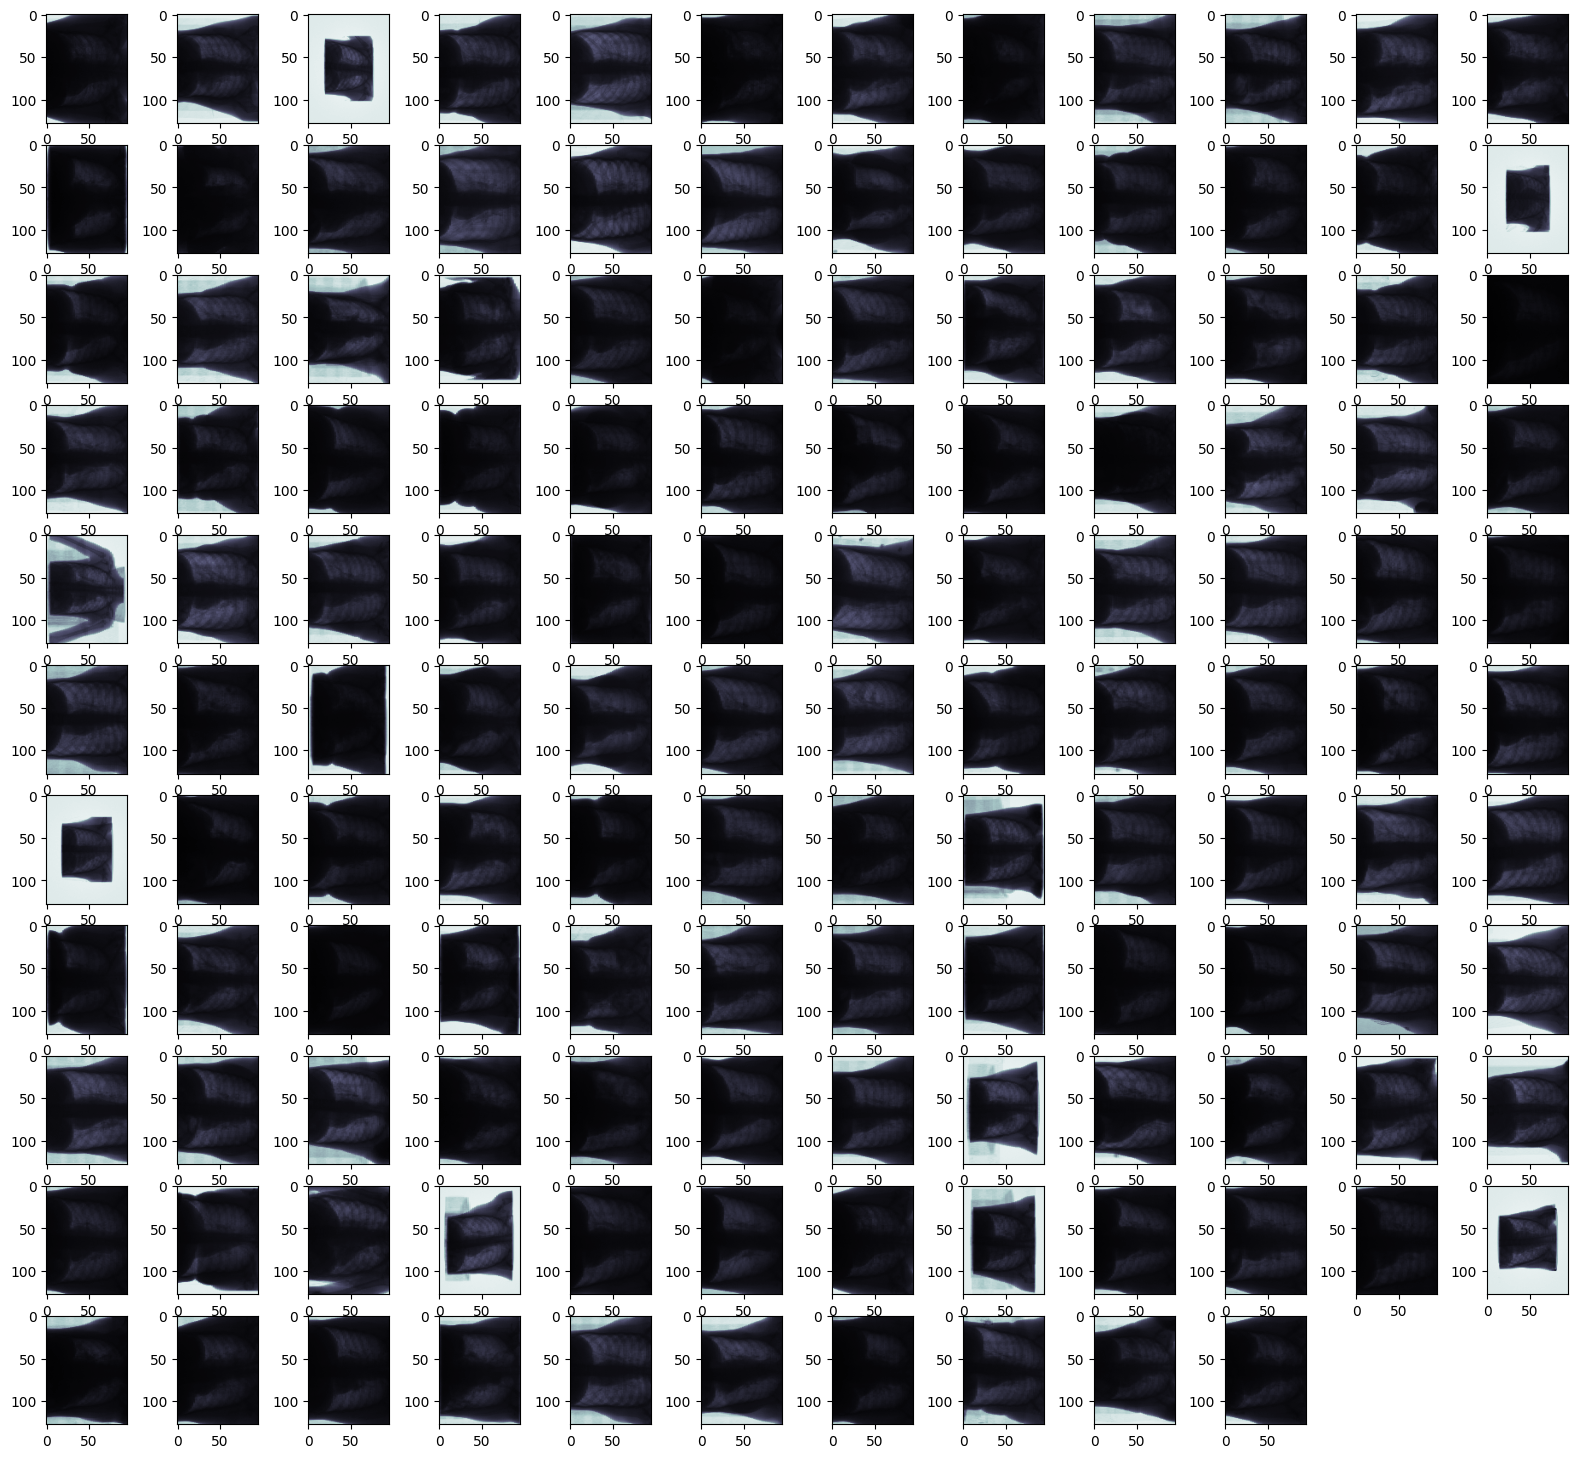

In [ ]:
plt.figure(figsize=(20,20))
for i in range(0,len(inp_np_HE_cut)):
   plt.subplot(12,12,i+1)
   plt.imshow(np.squeeze(inp_np_HE_cut[i,0:128,:,:]),cmap=plt.cm.bone,vmin=0,vmax=1.075)

In [ ]:
print(type(inp_np_HE))
print(type(inp_np_HE_cut))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Remove small object images

In [ ]:
inp_np_HE_cut = np.delete(inp_np_HE_cut,[2,23,48,72,103,111,115,119],axis=0)
inp_np_LE_cut = np.delete(inp_np_LE_cut,[2,23,48,72,103,111,115,119],axis=0)
print(inp_np_HE_cut.shape)

(122, 128, 96, 1)


In [ ]:
out_np_HE_cut = np.delete(out_np_HE_cut,[2,23,48,72,103,111,115,119],axis=0)
out_np_LE_cut = np.delete(out_np_LE_cut,[2,23,48,72,103,111,115,119],axis=0)
print(out_np_HE_cut.shape)

(122, 128, 96, 1)


# Create input images with 2 channels (low and high energy CXRs) for dual-energy NN models

In [ ]:
inp_np_cut_dual = np.zeros([len(inp_np_HE_cut),128,96,2])
inp_np_cut_dual[:,:,:,0] = inp_np_LE_cut[:,:,:,0]   #[:,0:128,:,0]
inp_np_cut_dual[:,:,:,1] = inp_np_HE_cut[:,:,:,0]   #[:,128:256,:,0]

# Visualize all images

Total CXR (with scatter contribution)

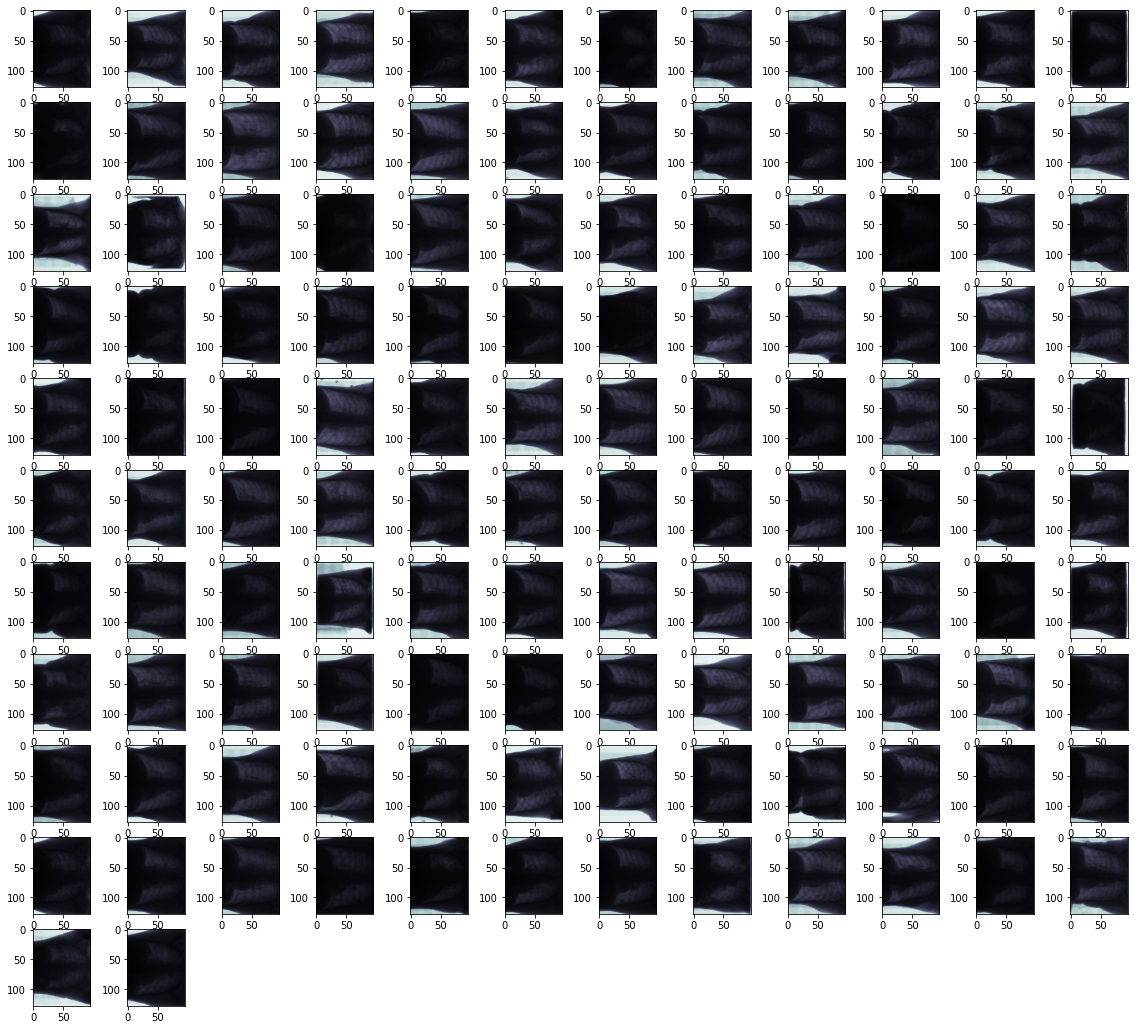

In [ ]:
plt.figure(figsize=(20,20))
for i in range(0,len(inp_np_HE_cut)):
   plt.subplot(12,12,i+1)
   plt.imshow(np.squeeze(inp_np_HE_cut[i,0:128,:,:]),cmap=plt.cm.bone,vmin=0,vmax=1.075)

Scatter images

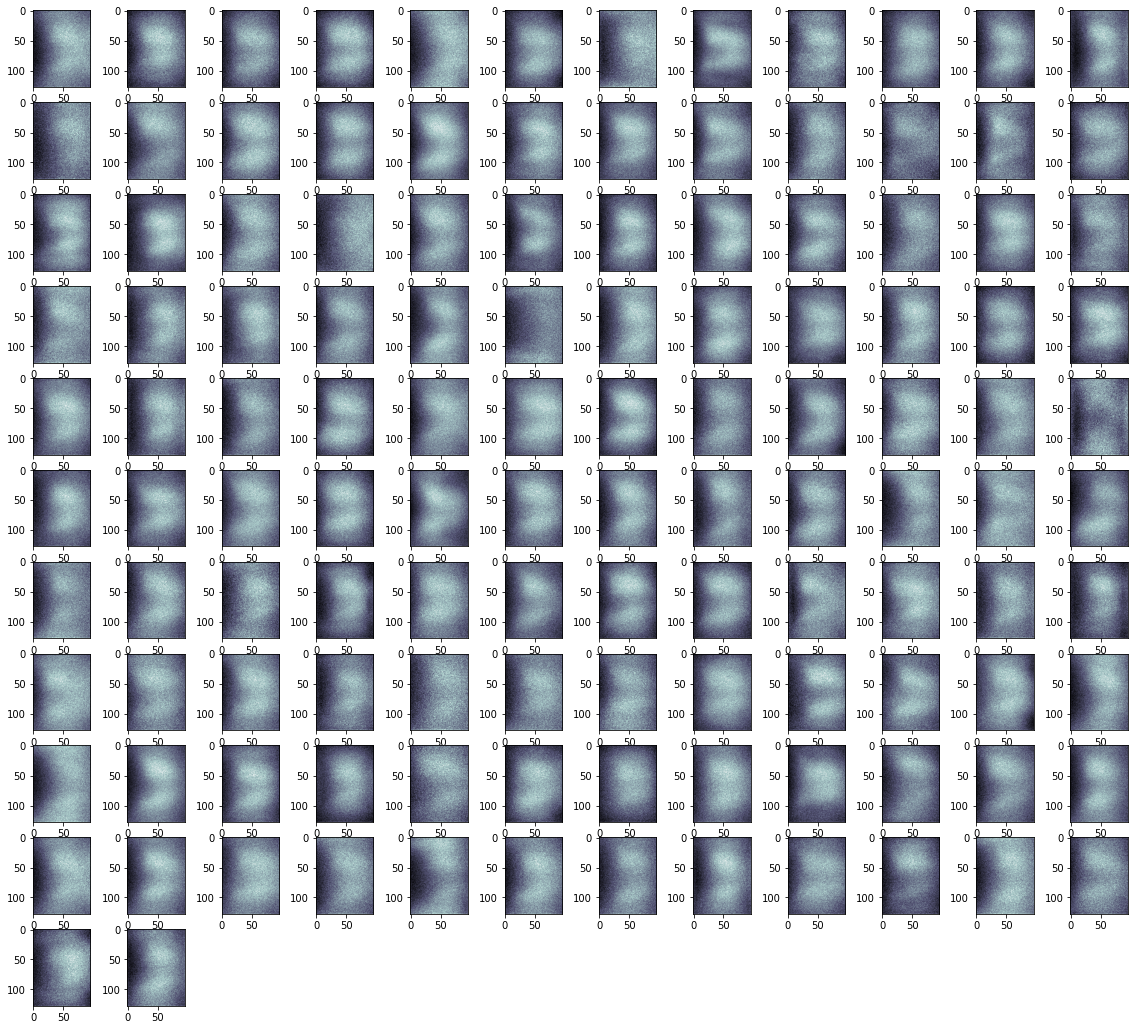

In [ ]:
plt.figure(figsize=(20,20))
for i in range(0,len(out_np_HE_cut)):
   plt.subplot(12,12,i+1)
   plt.imshow(np.squeeze(out_np_HE_cut[i,0:128,:,:]),cmap=plt.cm.bone) #,vmin=0,vmax=1.075)

# Output Normalization: Calculate Scatter Fraction as Scatter/Total

In [ ]:
out_np_LE_norm = np.zeros_like(out_np_LE_cut)
out_np_HE_norm = np.zeros_like(out_np_HE_cut)
for i in range(0,len(out_np_LE_cut)):
  out_np_LE_norm[i,:,:,:] = out_np_LE_cut[i,:,:,:]/(inp_np_LE_cut[i,:,:,:]) #+0.01*inp_np[i,0:128,:,:].max())
  out_np_HE_norm[i,:,:,:] = out_np_HE_cut[i,:,:,:]/(inp_np_HE_cut[i,:,:,:]) #+0.01*inp_np[i,128:256,:,:].max())

print(out_np_HE_norm.shape)

(122, 128, 96, 1)


## Figure: Example of scatter fraction

(-0.5, 127.5, 95.5, -0.5)

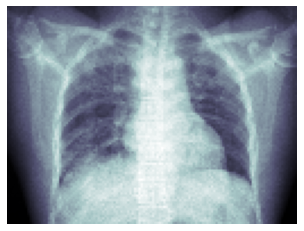

In [ ]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(out_np_HE_norm[0,:,:,0])),cmap=plt.cm.bone)
plt.axis('off')

# Split Data into Train and Validation Sets
We could split data by making a shuffle, but this way it is easier to identify the validation data, which will be used afterwards to assess the accuracy of the models.

In [ ]:
# High Energy
x_train_HE = inp_np_HE_cut[0:70,:,:,:]
x_val_HE = inp_np_HE_cut[70:100,:,:,:]
y_train_HE = out_np_HE_norm[0:70,:,:,:]
y_val_HE = out_np_HE_norm[70:100,:,:,:]

In [ ]:
# Low Energy
x_train_LE = inp_np_LE_cut[0:70,:,:,:]
x_val_LE = inp_np_LE_cut[70:100,:,:,:]
y_train_LE = out_np_LE_norm[0:70,:,:,:]
y_val_LE = out_np_LE_norm[70:100,:,:,:]

## Convert Numpy arrays to Tensor
This is to employ the data as input and output in the training process

In [ ]:
# High Energy
x_train_tf_HE = tf.convert_to_tensor(x_train_HE, tf.float32)
x_val_tf_HE = tf.convert_to_tensor(x_val_HE, tf.float32)
y_train_tf_HE = tf.convert_to_tensor(y_train_HE, tf.float32)
y_val_tf_HE = tf.convert_to_tensor(y_val_HE, tf.float32)

In [ ]:
# Low Energy
x_train_tf_LE = tf.convert_to_tensor(x_train_LE, tf.float32)
x_val_tf_LE = tf.convert_to_tensor(x_val_LE, tf.float32)
y_train_tf_LE = tf.convert_to_tensor(y_train_LE, tf.float32)
y_val_tf_LE = tf.convert_to_tensor(y_val_LE, tf.float32)

In [ ]:
x_train_tf_HE.shape

TensorShape([70, 128, 96, 1])

# NEURAL NETWORK: MultiResUnet - High Energy

## Load Keras Modules

In [ ]:
from keras_unet.models import custom_unet
from keras_unet.utils import get_augmented
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## MultiResUnet Architecture

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json


def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding,use_bias=False,kernel_initializer="he_normal")(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x
    x = Activation(activation, name=name)(x)
    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corresponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp
    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')
    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')
    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')
    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)
    return out


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')
    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)
    return out


def MultiResUnet(height, width, n_channels,filters):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))
    #inputs_SF = Input((height, width, n_channels))  #CFE: test to put the loss function inside the model

    mresblock1 = MultiResBlock(filters, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(filters, 4, mresblock1)

    mresblock2 = MultiResBlock(filters*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(filters*2, 3, mresblock2)

    mresblock3 = MultiResBlock(filters*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(filters*4, 2, mresblock3)

    mresblock4 = MultiResBlock(filters*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(filters*8, 1, mresblock4)

    mresblock5 = MultiResBlock(filters*16, pool4)

    print(inputs.shape)
    print(mresblock1.shape)
    print(mresblock2.shape)
    print(mresblock3.shape)
    print(mresblock4.shape)
    print(mresblock5.shape)

    up6 = concatenate([Conv2DTranspose(
       filters*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(filters*8, up6)

    up7 = concatenate([Conv2DTranspose(
       filters*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(filters*4, up7)

    up8 = concatenate([Conv2DTranspose(
       filters*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(filters*2, up8)

    up9 = concatenate([Conv2DTranspose(filters, (2, 2), strides=(
       2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(filters, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='relu')

    model = Model(inputs=[inputs], outputs=[conv10])

    # # Construct your custom loss as a tensor And Compile without specifying a loss
    # loss = K.mean(K.square(inputs_SF*inputs_T - outputs*input_T), axis=-1)
    # ## Add loss to model
    # model.add_loss(loss)

    return model

## Model Definition

In [ ]:
#Run this for MultiResUnet Network
filters=64
channels=1
mresunet=MultiResUnet(x_train_tf_HE.shape[1],x_train_tf_HE.shape[2],channels,filters)  #MultiResUnet(Ny,Nx,channels,filters)

(None, 128, 96, 1)
(None, 128, 96, 64)
(None, 64, 48, 128)
(None, 32, 24, 256)
(None, 16, 12, 512)
(None, 8, 6, 1709)


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
mresunet.compile(optimizer=opt, loss='MeanSquaredError')   #l1 NORM #MeanSquaredError #MeanAbsoluteError #mean_squared_logarithmic_error #root_mean_squared_error

#mresunet.compile(optimizer=opt)   #If loss function is inside the model

## Data Augmentation

In [ ]:
# Train data, provide the same seed and keyword arguments to the fit and flow methods
def get_augmented_mod(
    X_train, Y_train, batch_size=32, seed=0,
    data_gen_args=dict(rotation_range=0.0, width_shift_range=0.,
        height_shift_range=0.0, shear_range=0, zoom_range=[0.5,1],
        horizontal_flip=True, vertical_flip=True, fill_mode="nearest")):
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
    train_generator = zip(X_train_augmented, Y_train_augmented)
    return train_generator
    #return train_generator, X_train_augmented, Y_train_augmented

In [ ]:
train_gen = get_augmented_mod(x_train_tf_HE, y_train_tf_HE, batch_size=24,
   data_gen_args = dict(width_shift_range=0.0,height_shift_range=0.0,rotation_range=0.0,
       horizontal_flip=True,vertical_flip=True,fill_mode='nearest', zoom_range=[0.5,1]))

## Run Training

In [ ]:
#history6 = mresunet.fit(x_train_tf_HE, y_train_tf_HE,batch_size=32, steps_per_epoch=10, epochs=400,validation_data=(x_val_tf_HE,y_val_tf_HE))  #,steps_per_epoch=10, epochs=400, validation_data=(x_val_tf_HE,y_val_tf_HE)) #,callbacks=[checkpoint6])
history6 = mresunet.fit(train_gen, steps_per_epoch=10, epochs=600, validation_data=(x_val_tf_HE, y_val_tf_HE)) #,callbacks=[checkpoint6])

Epoch 1/600
10/10 [==============================] - 81s 3s/step - loss: 0.1996 - val_loss: 0.2771
Epoch 2/600
10/10 [==============================] - 6s 647ms/step - loss: 0.0501 - val_loss: 0.2690
Epoch 3/600
10/10 [==============================] - 6s 638ms/step - loss: 0.0341 - val_loss: 0.2537
Epoch 4/600
10/10 [==============================] - 6s 648ms/step - loss: 0.0288 - val_loss: 0.2223
Epoch 5/600
10/10 [==============================] - 6s 637ms/step - loss: 0.0269 - val_loss: 0.1401
Epoch 6/600
10/10 [==============================] - 6s 644ms/step - loss: 0.0249 - val_loss: 0.0656
Epoch 7/600
10/10 [==============================] - 6s 653ms/step - loss: 0.0238 - val_loss: 0.0390
Epoch 8/600
10/10 [==============================] - 6s 644ms/step - loss: 0.0220 - val_loss: 0.0321
Epoch 9/600
10/10 [==============================] - 6s 641ms/step - loss: 0.0217 - val_loss: 0.0303
Epoch 10/600
10/10 [==============================] - 7s 653ms/step - loss: 0.0202 - val_loss

## Plot Training and Validation Loss Functions

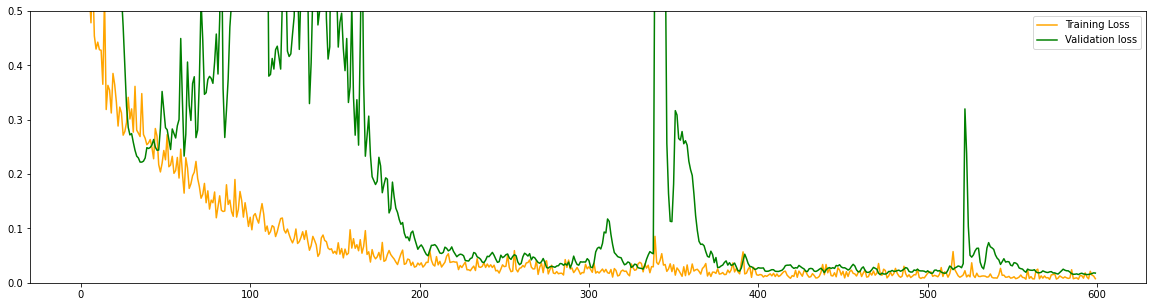

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

loss = np.array(history6.history['loss'])
var_loss = np.array(history6.history['val_loss'])
ax.plot(20*np.log(1+loss), 'orange', label='Training Loss')
ax.plot(20*np.log(1+var_loss), 'green', label='Validation loss')
ax.set_ylim([0, 0.5])
ax.legend()
fig.show()

## Plot the Scatter Fraction Estimation (1 case)

Text(0.5, 1.0, 'SCATTER Fraction (Reference)')

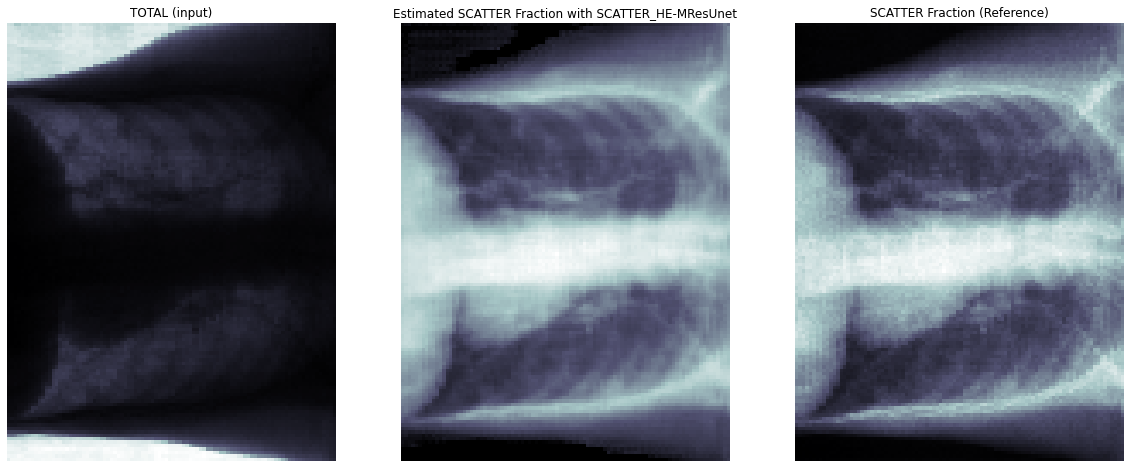

In [ ]:
img_index = 15 #54
test = tf.concat([x_val_tf_HE,y_val_tf_HE,x_val_tf_HE*y_val_tf_HE],-1)
test = np.expand_dims(test[img_index,:,:,:],axis=0)
estim = mresunet.predict(test)
TOT_img = np.squeeze(test[0,:,:,0]) #CT_img = np.squeeze(test)
ESTIM_img = np.squeeze(estim)
SCAT_img = np.squeeze(y_val_tf_HE[img_index,:,:,0]) #DOSE_img = np.squeeze(y_val_tf[img_index,:,:,:])

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.imshow(TOT_img,cmap=plt.cm.bone) #plt.imshow(np.concatenate((TOT_img[:,:,0],TOT_img[:,:,1]),axis=0),cmap=plt.cm.bone) #plt.imshow(CT_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('TOTAL (input)') #plt.title('CT (Input)')

plt.subplot(1,3,2)
plt.imshow(ESTIM_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Estimated SCATTER Fraction with SCATTER_HE-MResUnet') #plt.title('Estimated DOSE with CT2DOSE')

plt.subplot(1,3,3)
plt.imshow(SCAT_img,cmap=plt.cm.bone) #plt.imshow(DOSE_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('SCATTER Fraction (Reference)') #plt.title('DOSE (Reference)')

## Saved Trained Model

In [ ]:
loss = np.array(history6.history['loss'])
var_loss = np.array(history6.history['val_loss'])
loss_info = np.transpose(100*np.array([loss,var_loss]))
np.savetxt( "drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/LOSSINFO_HE600Cut_MRU_FracScatterTotal_NoRot_addloss_lambda03.csv", loss_info, fmt='%.3f', delimiter='\t')
np.savetxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/loss_HE600Cut_MRU_FracScatterTotal_NoRot_addloss_lambda03.csv',loss)
np.savetxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/Varloss_HE600Cut_MRU_FracScatterTotal_NoRot_addloss_lambda03.csv',var_loss)

In [ ]:
np.savetxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/MSE_val_HE600Cut_MRU_FracScatterTotal_NoRot_addloss_lambda03.csv',MAE_train)
np.savetxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/MSE_val_HE600Cut_MRU_FracScatterTotal_NoRot_addloss_lambda03.csv',MAE_val)

In [ ]:
# Save the entire model as a HDF5 file.
mresunet.save('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/SCATTER_HE600Cut_MRU_FracScatterTotal_NoRot_addloss_lambda03.h5')

# NEURAL NETWORK: MultiResUnet - Dual Energy

## Select Dual Energy Data

In [ ]:
x_train_dual = np.zeros((70,128,96,2))
x_val_dual = np.zeros((30,128,96,2))

x_train_dual[:,:,:,0] = x_train_LE[:,:,:,0]
x_train_dual[:,:,:,1] = x_train_HE[:,:,:,0]
x_val_dual[:,:,:,0] = x_val_LE[:,:,:,0]
x_val_dual[:,:,:,1] = x_val_HE[:,:,:,0]

x_train_tf_dual = tf.convert_to_tensor(x_train_dual, tf.float32)
x_val_tf_dual = tf.convert_to_tensor(x_val_dual, tf.float32)

In [ ]:
y_train_dual = np.zeros((70,128,96,2))
y_val_dual = np.zeros((30,128,96,2))

y_train_dual[:,:,:,0] = y_train_LE[:,:,:,0]
y_train_dual[:,:,:,1] = y_train_HE[:,:,:,0]
y_val_dual[:,:,:,0] = y_val_LE[:,:,:,0]
y_val_dual[:,:,:,1] = y_val_HE[:,:,:,0]

y_train_tf_dual = tf.convert_to_tensor(y_train_dual, tf.float32)
y_val_tf_dual = tf.convert_to_tensor(y_val_dual, tf.float32)

## Load Keras Modules

In [ ]:
from keras_unet.models import custom_unet
from keras_unet.utils import get_augmented
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

## MultiResUnet Architecture

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
#from keras.optimizers import Adam
#from keras.layers.advanced_activations import ELU, LeakyReLU


def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False,kernel_initializer="he_normal")(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x
    x = Activation(activation, name=name)(x)
    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corresponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp
    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')
    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')
    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')
    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)
    return out


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')
    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)
    return out


def MultiResUnet(height, width, n_channels,filters):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(filters, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(filters, 4, mresblock1)

    mresblock2 = MultiResBlock(filters*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(filters*2, 3, mresblock2)

    mresblock3 = MultiResBlock(filters*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(filters*4, 2, mresblock3)

    mresblock4 = MultiResBlock(filters*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(filters*8, 1, mresblock4)

    mresblock5 = MultiResBlock(filters*16, pool4)


    up6 = concatenate([Conv2DTranspose(
       filters*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(filters*8, up6)

    up7 = concatenate([Conv2DTranspose(
       filters*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(filters*4, up7)

    up8 = concatenate([Conv2DTranspose(
       filters*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(filters*2, up8)

    up9 = concatenate([Conv2DTranspose(filters, (2, 2), strides=(
       2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(filters, up9)

    conv10 = conv2d_bn(mresblock9, 2, 1, 1, activation='relu') #filters=2 in order to have 2 channels in the output (second parameter of the input of conv2d_bn)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

## Model Definition

In [ ]:
#Run this for MultiResUnet Network
filters=64
channels=2
mresunet=MultiResUnet(x_train_tf_dual.shape[1],x_train_tf_dual.shape[2],channels,filters)  #MultiResUnet(Ny,Nx,channels,filters)

(None, 128, 96, 2)
(None, 128, 96, 64)
(None, 64, 48, 128)
(None, 32, 24, 256)
(None, 16, 12, 512)
(None, 8, 6, 1709)


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
mresunet.compile(optimizer=opt, loss='MeanSquaredError')   #l1 NORM #MeanSquaredError #MeanAbsoluteError #mean_squared_logarithmic_error #root_mean_squared_error

## Data Augmentation

In [ ]:
# Train data, provide the same seed and keyword arguments to the fit and flow methods
def get_augmented_mod(
    X_train, Y_train, batch_size=32, seed=0,
    data_gen_args=dict(rotation_range=0.0, width_shift_range=0.,
        height_shift_range=0.0, shear_range=0, zoom_range=[0.5,1],
        horizontal_flip=True, vertical_flip=True, fill_mode="nearest")):
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
    train_generator = zip(X_train_augmented, Y_train_augmented)
    return train_generator
    #return train_generator, X_train_augmented, Y_train_augmented

In [ ]:
train_gen = get_augmented(x_train_tf_dual[:,:,:,:], y_train_tf_dual[:,:,:,:], batch_size=24,
    data_gen_args = dict(width_shift_range=0.0,height_shift_range=0.0,rotation_range=0.0,
        horizontal_flip=True,vertical_flip=True,fill_mode='nearest', zoom_range=[0.5,1]))

## Run Training

In [ ]:
history6 = mresunet.fit(train_gen,steps_per_epoch=10, epochs=600, validation_data=(x_val_tf_dual, y_val_tf_dual)) #,callbacks=[checkpoint6])
#history6 = mresunet.fit(train_gen,y=None, epochs=600, validation_data=([yy],[]))  #,steps_per_epoch=10, epochs=400,) #,callbacks=[checkpoint6])

Epoch 1/600
10/10 [==============================] - 58s 3s/step - loss: 0.1496 - val_loss: 0.3191
Epoch 2/600
10/10 [==============================] - 7s 663ms/step - loss: 0.0477 - val_loss: 0.3187
Epoch 3/600
10/10 [==============================] - 7s 661ms/step - loss: 0.0378 - val_loss: 0.3044
Epoch 4/600
10/10 [==============================] - 7s 658ms/step - loss: 0.0329 - val_loss: 0.2736
Epoch 5/600
10/10 [==============================] - 7s 652ms/step - loss: 0.0315 - val_loss: 0.1943
Epoch 6/600
10/10 [==============================] - 7s 657ms/step - loss: 0.0299 - val_loss: 0.1128
Epoch 7/600
10/10 [==============================] - 7s 659ms/step - loss: 0.0286 - val_loss: 0.0708
Epoch 8/600
10/10 [==============================] - 7s 663ms/step - loss: 0.0267 - val_loss: 0.0465
Epoch 9/600
10/10 [==============================] - 7s 675ms/step - loss: 0.0264 - val_loss: 0.0342
Epoch 10/600
10/10 [==============================] - 7s 673ms/step - loss: 0.0246 - val_loss

## Plot Training and Validation Loss Functions

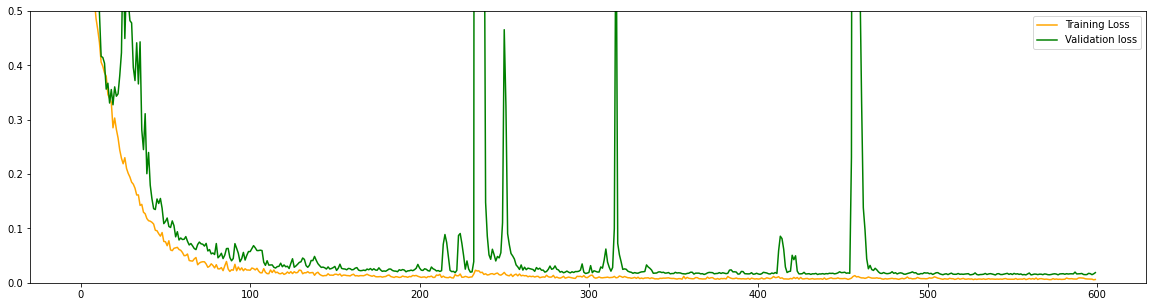

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

loss = np.array(history6.history['loss'])
var_loss = np.array(history6.history['val_loss'])
ax.plot(20*np.log(1+loss), 'orange', label='Training Loss')
ax.plot(20*np.log(1+var_loss), 'green', label='Validation loss')
ax.set_ylim([0, 0.5])
ax.legend()
fig.show()

## Plot the Scatter Fraction Estimation (1 case)

1/1 [==============================] - 0s 50ms/step


Text(0.5, 1.0, 'SCATTER FRACTION HE (Reference)')

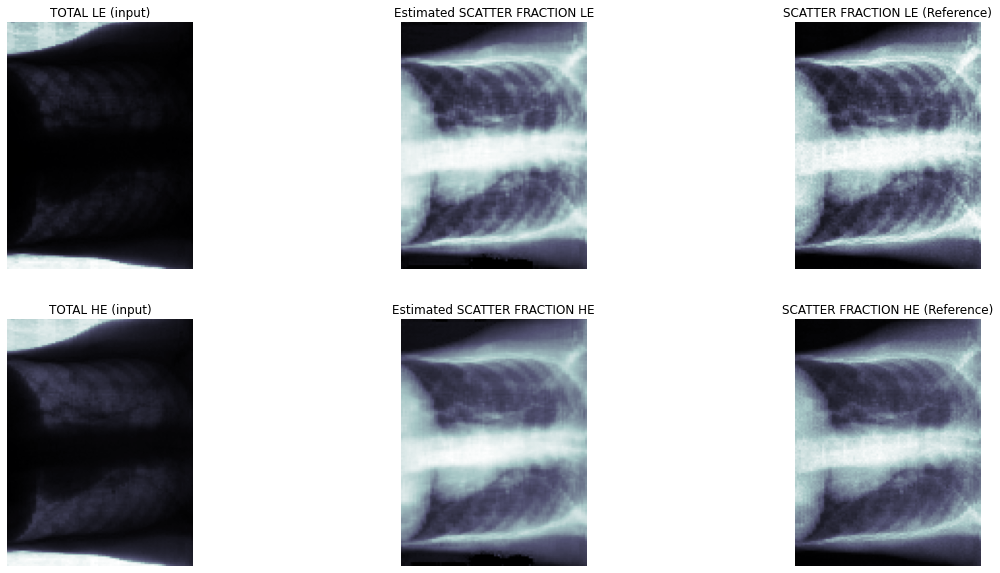

In [ ]:
img_index = 15 #54
# test = tf.concat([x_val_tf_LE,x_val_tf_HE,y_val_tf_HE],-1)
# test = np.expand_dims(test[img_index,:,:,:],axis=0)
test = np.expand_dims(x_val_tf_dual[img_index,:,:,:],axis=0)
estim = mresunet.predict(test)
TOT_img_LE = np.squeeze(test[0,:,:,0]) #CT_img = np.squeeze(test)
TOT_img_HE = np.squeeze(test[0,:,:,1])
ESTIM_img_LE = np.squeeze(estim[0,:,:,0])
ESTIM_img_HE = np.squeeze(estim[0,:,:,1])
SCAT_img_LE = np.squeeze(y_val_tf_dual[img_index,:,:,0]) #DOSE_img = np.squeeze(y_val_tf[img_index,:,:,:])
SCAT_img_HE = np.squeeze(y_val_tf_dual[img_index,:,:,1])

plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
plt.imshow(TOT_img_LE,cmap=plt.cm.bone) #plt.imshow(np.concatenate((TOT_img[:,:,0],TOT_img[:,:,1]),axis=0),cmap=plt.cm.bone) #plt.imshow(CT_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('TOTAL LE (input)') #plt.title('CT (Input)')

plt.subplot(2,3,2)
plt.imshow(ESTIM_img_LE, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Estimated SCATTER FRACTION LE') #plt.title('Estimated DOSE with CT2DOSE')

plt.subplot(2,3,3)
plt.imshow(SCAT_img_LE,cmap=plt.cm.bone) #plt.imshow(DOSE_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('SCATTER FRACTION LE (Reference)') #plt.title('DOSE (Reference)')

plt.subplot(2,3,4)
plt.imshow(TOT_img_HE,cmap=plt.cm.bone) #plt.imshow(np.concatenate((TOT_img[:,:,0],TOT_img[:,:,1]),axis=0),cmap=plt.cm.bone) #plt.imshow(CT_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('TOTAL HE (input)') #plt.title('CT (Input)')

plt.subplot(2,3,5)
plt.imshow(ESTIM_img_HE, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Estimated SCATTER FRACTION HE') #plt.title('Estimated DOSE with CT2DOSE')

plt.subplot(2,3,6)
plt.imshow(SCAT_img_HE,cmap=plt.cm.bone) #plt.imshow(DOSE_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('SCATTER FRACTION HE (Reference)') #plt.title('DOSE (Reference)')

## Save Trained Model

In [ ]:
loss = np.array(history6.history['loss'])
var_loss = np.array(history6.history['val_loss'])
loss_info = np.transpose(100*np.array([loss,var_loss]))
np.savetxt( "drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/LOSSINFO_DUAL600Cut_MRU22ch_FracScatterTotal_NoRot_Original.csv", loss_info, fmt='%.3f', delimiter='\t')
np.savetxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/loss_DUAL600Cut_MRU22ch_FracScatterTotal_NoRot_Original.csv',loss)
np.savetxt('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/Varloss_DUAL600Cut_MRU22ch_FracScatterTotal_NoRot_Original.csv',var_loss)

In [ ]:
# Save the entire model as a HDF5 file.
mresunet.save('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/SCATTER_DUAL600Cut_MRU22ch_FracScatterTotal_NoRot_Original.h5')

# ANALYSIS OF ESTIMATED AND CORRECTED SCATTER

## Load Trained Models

In [ ]:
model_HE = tf.keras.models.load_model('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/SCATTER_HE600Cut_MRU_FracScatterTotal_NoRot_Original_DetScat.h5',compile=False)
model_DUAL_HELE = tf.keras.models.load_model('drive/My Drive/ENERGIA_DUAL_IMAGENES/MODELS_BIEN_5e9/SCATTER_DUAL600Cut_MRU22ch_FracScatterTotal_NoRot_Original.h5',compile=False)

## Load Reference Scatter, No-Scatter & Total Projection





In [ ]:
total_HE = load_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_T_5e9.csv')
scat_ref_HE = load_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_S_5e9.csv')
noscat_ref_HE = load_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_HE_NS_5e9.csv')
total_LE = load_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_T_5e9.csv')
scat_ref_LE = load_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_S_5e9.csv')
noscat_ref_LE = load_csv('drive/My Drive/ENERGIA_DUAL_IMAGENES/TRAINING_DATA_BIEN/PROJ_LE_NS_5e9.csv')

## Crop Images

In [ ]:
scat_ref_HE = scat_ref_HE[:,:,16:112,:]
total_HE = total_HE[:,:,16:112,:]
noscat_ref_HE = noscat_ref_HE[:,:,16:112,:]

scat_ref_LE = scat_ref_LE[:,:,16:112,:]
total_LE = total_LE[:,:,16:112,:]
noscat_ref_LE = noscat_ref_LE[:,:,16:112,:]

print(scat_ref_HE.shape)

(130, 128, 96, 1)


In [ ]:
# Remove small objects
scat_ref_HE = np.delete(scat_ref_HE,[2,23,48,72,103,111,115,119],axis=0)
total_HE = np.delete(total_HE,[2,23,48,72,103,111,115,119],axis=0)
noscat_ref_HE = np.delete(noscat_ref_HE,[2,23,48,72,103,111,115,119],axis=0)

scat_ref_LE = np.delete(scat_ref_LE,[2,23,48,72,103,111,115,119],axis=0)
total_LE = np.delete(total_LE,[2,23,48,72,103,111,115,119],axis=0)
noscat_ref_LE = np.delete(noscat_ref_LE,[2,23,48,72,103,111,115,119],axis=0)

print(scat_ref_HE.shape)

(122, 128, 96, 1)


In [ ]:
total_dual = np.zeros((122,128,96,2))
total_dual[:,:,:,0] = total_LE[:,:,:,0]
total_dual[:,:,:,1] = total_HE[:,:,:,0]

## Neural Network Estimations & Metrics

In [ ]:
S_REF_HE = np.zeros((122,128,96))
NS_REF_HE = np.zeros((122,128,96))
S_REF_LE = np.zeros((122,128,96))
NS_REF_LE = np.zeros((122,128,96))

ST_ESTIM_HE = np.zeros((122,128,96))
ST_ESTIM_DUAL_DUALHE = np.zeros((122,128,96))
ST_ESTIM_DUAL_DUALLE = np.zeros((122,128,96))

S_ESTIM_HE = np.zeros((122,128,96))
S_ESTIM_DUAL_DUALHE = np.zeros((122,128,96))
S_ESTIM_DUAL_DUALLE = np.zeros((122,128,96))

NS_ESTIM_HE = np.zeros((122,128,96))
NS_ESTIM_DUAL_DUALHE = np.zeros((122,128,96))
NS_ESTIM_DUAL_DUALLE = np.zeros((122,128,96))

DIF_HE_rel = np.zeros((122,128,96))
DIF_DUAL_DUALHE_rel = np.zeros((122,128,96))
DIF_DUAL_DUALLE_rel = np.zeros((122,128,96))

DIF_HE_NSrel = np.zeros((122,128,96))
DIF_DUAL_DUALHE_NSrel = np.zeros((122,128,96))
DIF_DUAL_DUALLE_NSrel = np.zeros((122,128,96))

MAPE_NS_HE = np.zeros((122,1))
MAPE_NS_LE = np.zeros((122,1))
MAPE_NS_DUAL_DUALLE = np.zeros((122,1))

SSIM_NS_HE0 = np.zeros((122,1))
SSIM_NS_DUAL0_DUALHE = np.zeros((122,1))
SSIM_NS_DUAL0_DUALLE = np.zeros((122,1))

SSIM_NS_HE1 = np.zeros((122,128,96))
SSIM_NS_DUAL1_DUALHE = np.zeros((122,128,96))
SSIM_NS_DUAL1_DUALLE = np.zeros((122,128,96))

SSIM_NS_HE2 = np.zeros((122,128,96))
SSIM_NS_DUAL2_DUALHE = np.zeros((122,128,96))
SSIM_NS_DUAL2_DUALLE = np.zeros((122,128,96))

MSE_NS_HE = np.zeros((122,1))
MSE_NS_DUAL_DUALHE = np.zeros((122,1))
MSE_NS_DUAL_DUALLE = np.zeros((122,1))

for idx in range(122):

  ## HE MODEL
  test_HE = np.expand_dims(total_HE[idx,:,:,:],axis=0)
  estim_HE = model_HE.predict(test_HE)
  #TOT_LE = np.squeeze(test_LE)
  ST_ESTIM_HE[idx,:,:] = np.squeeze(estim_HE)
  S_ESTIM_HE[idx,:,:] = ST_ESTIM_HE[idx,:,:]*np.squeeze(total_HE[idx,:,:,:])
  NS_ESTIM_HE[idx,:,:] = np.squeeze(total_HE[idx,:,:,:])-S_ESTIM_HE[idx,:,:]
  #S_ESTIM_HE[idx,:,:] = np.where(S_ESTIM_HE[idx,:,:] < 0,0,S_ESTIM_HE[idx,:,:])
  S_REF_HE[idx,:,:] = np.squeeze(scat_ref_HE[idx,:,:,:])
  NS_REF_HE[idx,:,:] = np.squeeze(noscat_ref_HE[idx,:,:,:])
  #DIF_HE_abs = abs(S_REF_HE-S_ESTIM_HE[idx,:,:])
  DIF_HE_rel[idx,:,:] = abs(S_REF_HE[idx,:,:]-S_ESTIM_HE[idx,:,:])/(S_REF_HE[idx,:,:]+S_ESTIM_HE[idx,:,:])
  DIF_HE_NSrel[idx,:,:] = abs(NS_REF_HE[idx,:,:]-NS_ESTIM_HE[idx,:,:])/(NS_REF_HE[idx,:,:]+NS_ESTIM_HE[idx,:,:])
  MAPE_NS_HE[idx,:] = mean_absolute_percentage_error(NS_REF_HE[idx,:,:],NS_ESTIM_HE[idx,:,:])
  MSE_NS_HE[idx,:] = mean_squared_error(NS_REF_HE[idx,:,:],NS_ESTIM_HE[idx,:,:])
  SSIM_NS_single = ssim(NS_REF_HE[idx,:,:],NS_ESTIM_HE[idx,:,:],gradient=True,full=True)
  SSIM_NS_HE0[idx,:] = SSIM_NS_single[0]
  SSIM_NS_HE1[idx,:,:] = SSIM_NS_single[1]
  SSIM_NS_HE2[idx,:,:] = SSIM_NS_single[2]


  ## DUAL-HE&LE MODEL
  test_DUAL_HELE = np.expand_dims(total_dual[idx,:,:,:],axis=0) #np.expand_dims(x_val_DUAL_2chn[idx,:,1:129,:],axis=0)
  estim_DUAL_HELE = model_DUAL_HELE.predict(test_DUAL_HELE)
  ST_ESTIM_DUAL_DUALLE[idx,:,:] = np.squeeze(estim_DUAL_HELE[:,:,:,0])
  S_ESTIM_DUAL_DUALLE[idx,:,:] = ST_ESTIM_DUAL_DUALLE[idx,:,:]*np.squeeze(total_LE[idx,:,:,:])
  NS_ESTIM_DUAL_DUALLE[idx,:,:] = np.squeeze(total_LE[idx,:,:,:])-S_ESTIM_DUAL_DUALLE[idx,:,:]
  DIF_DUAL_DUALLE_rel[idx,:,:] = abs(S_REF_LE[idx,:,:]-S_ESTIM_DUAL_DUALLE[idx,:,:])/(S_REF_LE[idx,:,:]+S_ESTIM_DUAL_DUALLE[idx,:,:])
  DIF_DUAL_DUALLE_NSrel[idx,:,:] = abs(NS_REF_LE[idx,:,:]-NS_ESTIM_DUAL_DUALLE[idx,:,:])/(NS_REF_LE[idx,:,:]+NS_ESTIM_DUAL_DUALLE[idx,:,:])
  MAPE_NS_DUAL_DUALLE[idx,:] = mean_absolute_percentage_error(NS_REF_LE[idx,:,:],NS_ESTIM_DUAL_DUALLE[idx,:,:])
  MSE_NS_DUAL_DUALLE[idx,:] = mean_squared_error(NS_REF_LE[idx,:,:],NS_ESTIM_DUAL_DUALLE[idx,:,:])
  SSIM_NS_dual_DUALLE = ssim(NS_REF_LE[idx,:,:],NS_ESTIM_DUAL_DUALLE[idx,:,:],gradient=True,full=True)
  SSIM_NS_DUAL0_DUALLE[idx,:] = SSIM_NS_dual_DUALLE[0]
  SSIM_NS_DUAL1_DUALLE[idx,:,:] = SSIM_NS_dual_DUALLE[1]
  SSIM_NS_DUAL2_DUALLE[idx,:,:] = SSIM_NS_dual_DUALLE[2]


  ST_ESTIM_DUAL_DUALHE[idx,:,:] = np.squeeze(estim_DUAL_HELE[:,:,:,1])
  S_ESTIM_DUAL_DUALHE[idx,:,:] = ST_ESTIM_DUAL_DUALHE[idx,:,:]*np.squeeze(total_HE[idx,:,:,:])
  NS_ESTIM_DUAL_DUALHE[idx,:,:] = np.squeeze(total_HE[idx,:,:,:])-S_ESTIM_DUAL_DUALHE[idx,:,:]
  DIF_DUAL_DUALHE_rel[idx,:,:] = abs(S_REF_HE[idx,:,:]-S_ESTIM_DUAL_DUALHE[idx,:,:])/(S_REF_HE[idx,:,:]+S_ESTIM_DUAL_DUALHE[idx,:,:])
  DIF_DUAL_DUALHE_NSrel[idx,:,:] = abs(NS_REF_HE[idx,:,:]-NS_ESTIM_DUAL_DUALHE[idx,:,:])/(NS_REF_HE[idx,:,:]+NS_ESTIM_DUAL_DUALHE[idx,:,:])
  MAPE_NS_DUAL_DUALHE[idx,:] = mean_absolute_percentage_error(NS_REF_HE[idx,:,:],NS_ESTIM_DUAL_DUALHE[idx,:,:])
  MSE_NS_DUAL_DUALHE[idx,:] = mean_squared_error(NS_REF_HE[idx,:,:],NS_ESTIM_DUAL_DUALHE[idx,:,:])
  SSIM_NS_dual_DUALHE = ssim(NS_REF_HE[idx,:,:],NS_ESTIM_DUAL_DUALHE[idx,:,:],gradient=True,full=True)
  SSIM_NS_DUAL0_DUALHE[idx,:] = SSIM_NS_dual_DUALHE[0]
  SSIM_NS_DUAL1_DUALHE[idx,:,:] = SSIM_NS_dual_DUALHE[1]
  SSIM_NS_DUAL2_DUALHE[idx,:,:] = SSIM_NS_dual_DUALHE[2]

  print('iteracion',idx)

1/1 [==============================] - 2s 2s/step
iteracion 0
1/1 [==============================] - 0s 483ms/step
iteracion 1
1/1 [==============================] - 1s 921ms/step
iteracion 2
1/1 [==============================] - 0s 492ms/step
iteracion 3
1/1 [==============================] - 0s 482ms/step
iteracion 4
1/1 [==============================] - 0s 495ms/step
iteracion 5
1/1 [==============================] - 2s 2s/step
iteracion 6
1/1 [==============================] - 0s 494ms/step
iteracion 7
1/1 [==============================] - 0s 481ms/step
iteracion 8
1/1 [==============================] - 1s 726ms/step
iteracion 9
1/1 [==============================] - 0s 484ms/step
iteracion 10
1/1 [==============================] - 0s 473ms/step
iteracion 11
1/1 [==============================] - 0s 493ms/step
iteracion 12
1/1 [==============================] - 1s 774ms/step
iteracion 13
1/1 [==============================] - 0s 474ms/step
iteracion 14
1/1 [=====================

## Plot Metrics

In [4]:
# SINGLE HE
MSE_boxplt_ROI_HE = np.load('drive/My Drive/ENERGIA_DUAL_IMAGENES/METRICS_SDD/MSE_SDD_Single.npy')
MAPE_boxplt_ROI_HE = np.load('drive/My Drive/ENERGIA_DUAL_IMAGENES/METRICS_SDD/MAPE_SDD_Single.npy')
SSIM_boxplt_ROI_HE = np.load('drive/My Drive/ENERGIA_DUAL_IMAGENES/METRICS_SDD/SSIM_SDD_Single.npy')
EREL_boxplt_ROI_HE = np.load('drive/My Drive/ENERGIA_DUAL_IMAGENES/METRICS_SDD/EREL_SDD_Single.npy')

In [8]:
# DUAL HE - 2 CHANNEL
MSE_boxplt_ROI_DUAL_DUALHE = np.load('drive/My Drive/ENERGIA_DUAL_IMAGENES/METRICS_SDD/MSE_SDD_DUAL_DUALHE.npy')
MAPE_boxplt_ROI_DUAL_DUALHE = np.load('drive/My Drive/ENERGIA_DUAL_IMAGENES/METRICS_SDD/MAPE_SDD_DUAL_DUALHE.npy')
SSIM_boxplt_ROI_DUAL_DUALHE = np.load('drive/My Drive/ENERGIA_DUAL_IMAGENES/METRICS_SDD/SSIM_SDD_DUAL_DUALHE.npy')
EREL_boxplt_ROI_DUAL_DUALHE = np.load('drive/My Drive/ENERGIA_DUAL_IMAGENES/METRICS_SDD/EREL_SDD_DUAL_DUALHE.npy')

In [17]:
MSE_boxplot = np.zeros((len(MSE_boxplt_ROI_HE),2))
MSE_boxplot[:,0] = MSE_boxplt_ROI_HE[:,8] #single model
MSE_boxplot[:,1] = MSE_boxplt_ROI_DUAL_DUALHE[:,8] #dual model

MAPE_boxplot = np.zeros((len(MAPE_boxplt_ROI_HE),2))
MAPE_boxplot[:,0] = MAPE_boxplt_ROI_HE[:,8] #single model
MAPE_boxplot[:,1] = MAPE_boxplt_ROI_DUAL_DUALHE[:,8]*100 #dual model

SSIM_boxplot = np.zeros((len(SSIM_boxplt_ROI_HE),2))
SSIM_boxplot[:,0] = SSIM_boxplt_ROI_HE[:,8] #single model
SSIM_boxplot[:,1] = SSIM_boxplt_ROI_DUAL_DUALHE[:,8] #dual model

EREL_boxplot = np.zeros((len(EREL_boxplt_ROI_HE),2))
EREL_boxplot[:,0] = EREL_boxplt_ROI_HE[:,8] #single model
EREL_boxplot[:,1] = EREL_boxplt_ROI_DUAL_DUALHE[:,8] #dual model

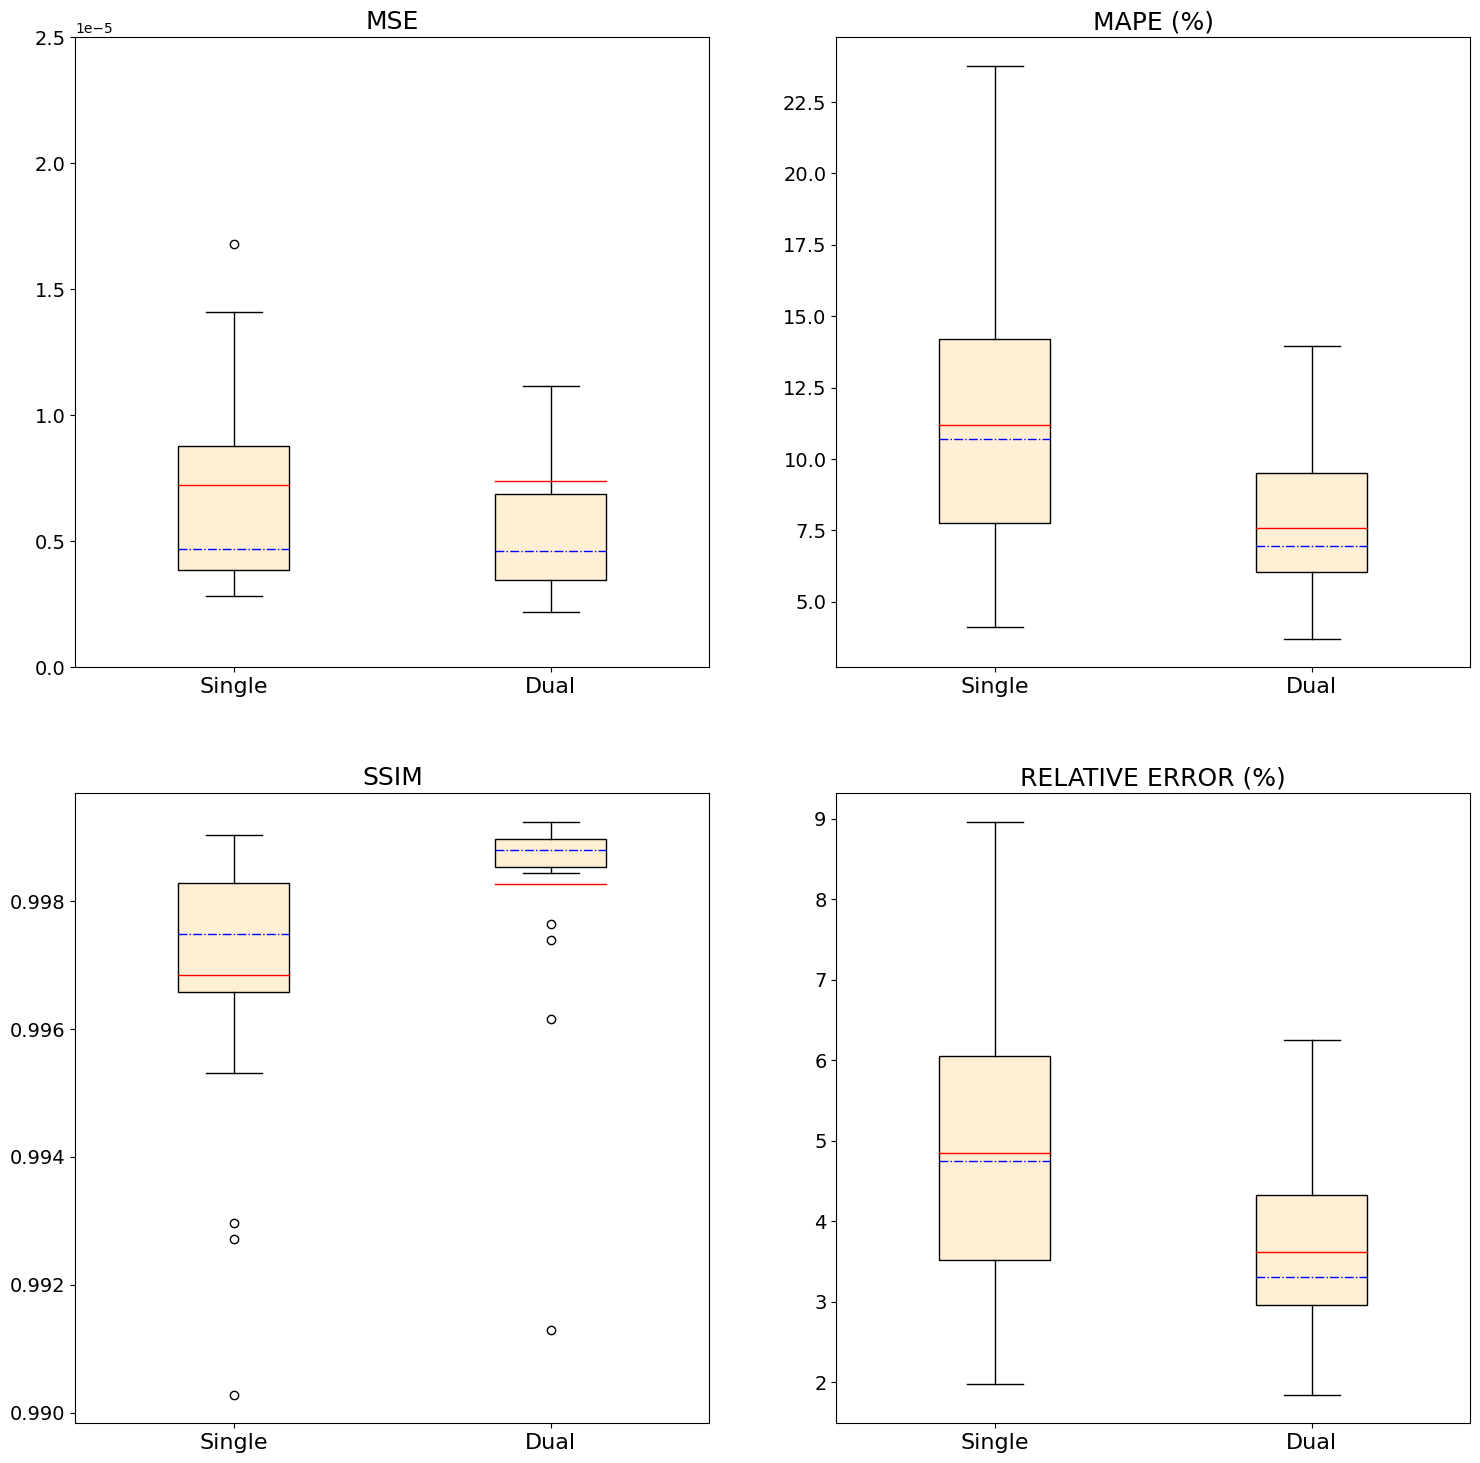

In [18]:
#MultipleBoxplot - Contrast Improvement
labels = ['Single', 'Dual']
median_dict = dict(color='blue',linestyle='-.')
mean_dict = dict(color='red', linestyle='-')
box_dict = dict(facecolor='papayawhip')

fig = plt.figure(figsize=(18,18))

plt.subplot(221)
plt.boxplot(MSE_boxplot, vert=True, patch_artist=True, labels=labels, widths=0.35, showmeans=True, meanline=True, medianprops=median_dict, meanprops=mean_dict, boxprops=box_dict) #whis=(0,100)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.ylim((0,2.5*1e-5))
plt.title('MSE',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)

plt.subplot(222)
plt.boxplot(MAPE_boxplot, vert=True, patch_artist=True, labels=labels, widths=0.35, showmeans=True, meanline=True, medianprops=median_dict, meanprops=mean_dict, boxprops=box_dict) #whis=(0,100)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('MAPE (%)',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)

plt.subplot(223)
plt.boxplot(SSIM_boxplot, vert=True, patch_artist=True, labels=labels, widths=0.35, showmeans=True, meanline=True, medianprops=median_dict, meanprops=mean_dict, boxprops=box_dict) #whis=(0,100)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('SSIM',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)

plt.subplot(224)
plt.boxplot(EREL_boxplot, vert=True, patch_artist=True, labels=labels, widths=0.35, showmeans=True, meanline=True, medianprops=median_dict, meanprops=mean_dict, boxprops=box_dict) #whis=(0,100)
#plt.setp(bp['whiskers'], color='black')
#plt.ylabel('observed value')
plt.title('RELATIVE ERROR (%)',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14);
